In [81]:
# !pip install imbalanced-learn
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# Menetapkan Seed agar hasil konsisten (Scientifically Sound)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print("Tahap 1: Inisialisasi selesai.")

Tahap 1: Inisialisasi selesai.


In [82]:
# Cari 20 Fitur Terpenting (daripada hanya 10)
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf.fit(X, y)

# Ambil 20 fitur terbaik
top_features = pd.Series(rf.feature_importances_, index=X.columns).nlargest(20).index.tolist()
X_selected = X[top_features]

print(f"Menggunakan 20 Fitur Terbaik. Fitur utama: {top_features[0]}, {top_features[1]}")

Menggunakan 20 Fitur Terbaik. Fitur utama: COURSE ID, 29


In [87]:
import pandas as pd

# Data untuk Tabel 1
data_tabel_1 = {
    'Skenario Eksperimen': [
        'Model Deep Learning Standar (Baseline)', 
        'Model Deep Learning Teroptimasi (Proposed)'
    ],
    'Metode': [
        'Tanpa SMOTE & K-Fold', 
        'SMOTE + K-Fold + Feature Selection (Top 20)'
    ],
    'Akurasi Rata-rata (%)': [
        '17.24%', 
        '22.07%'
    ]
}

# Membuat DataFrame
df_tabel_1 = pd.DataFrame(data_tabel_1)

print("--- DATA UNTUK TABEL 1 (SALIN KE BAB 4.1) ---")
print(df_tabel_1.to_string(index=False))

--- DATA UNTUK TABEL 1 (SALIN KE BAB 4.1) ---
                       Skenario Eksperimen                                      Metode Akurasi Rata-rata (%)
    Model Deep Learning Standar (Baseline)                        Tanpa SMOTE & K-Fold                17.24%
Model Deep Learning Teroptimasi (Proposed) SMOTE + K-Fold + Feature Selection (Top 20)                22.07%


In [88]:
import pandas as pd
from IPython.display import display, HTML

# 1. Menyiapkan data untuk Tabel 1
# Angka 17.24% adalah baseline awal Anda
# Angka 22.07% adalah hasil optimasi K-Fold + SMOTE + Feature Selection
data_tabel_1 = {
    'Skenario Eksperimen': [
        'Model Deep Learning Standar (Baseline)', 
        'Model Deep Learning Teroptimasi (Proposed Method)'
    ],
    'Metode / Teknik': [
        'Tanpa SMOTE, Tanpa K-Fold, 30 Fitur', 
        'SMOTE + Stratified 5-Fold + Seleksi 20 Fitur Terbaik'
    ],
    'Akurasi (%)': [17.24, 22.07]
}

# 2. Membuat DataFrame
df_hasil = pd.DataFrame(data_tabel_1)

# 3. Menampilkan Tabel dengan format yang rapi
print("--- DATA UNTUK TABEL 1 (SALIN KE BAB 4.1 PENELITIAN ANDA) ---")
display(HTML(df_hasil.to_html(index=False)))

# 4. Menghitung persentase peningkatan untuk bahan narasi di Pembahasan
peningkatan = ((22.07 - 17.24) / 17.24) * 100
print(f"\nCatatan Narasi: Model mengalami peningkatan performa sebesar {peningkatan:.2f}% dibanding baseline.")

--- DATA UNTUK TABEL 1 (SALIN KE BAB 4.1 PENELITIAN ANDA) ---


Skenario Eksperimen,Metode / Teknik,Akurasi (%)
Model Deep Learning Standar (Baseline),"Tanpa SMOTE, Tanpa K-Fold, 30 Fitur",17.24
Model Deep Learning Teroptimasi (Proposed Method),SMOTE + Stratified 5-Fold + Seleksi 20 Fitur Terbaik,22.07



Catatan Narasi: Model mengalami peningkatan performa sebesar 28.02% dibanding baseline.


In [89]:
# Copy dan paste sel ini di paling bawah notebook
print("="*60)
print("{:^60}".format("TABEL 1: PERBANDINGAN AKURASI"))
print("="*60)
print("{:<30} {:<15} {:<10}".format("Skenario", "Metode", "Akurasi"))
print("-"*60)
print("{:<30} {:<15} {:<10}".format("Model Standar", "Baseline", "17.24%"))
print("{:<30} {:<15} {:<10}".format("Model Teroptimasi", "Proposed", "22.07%"))
print("="*60)

               TABEL 1: PERBANDINGAN AKURASI                
Skenario                       Metode          Akurasi   
------------------------------------------------------------
Model Standar                  Baseline        17.24%    
Model Teroptimasi              Proposed        22.07%    


In [83]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
all_accuracies = []

for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    smote = SMOTE(random_state=SEED, k_neighbors=1)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    enc = OneHotEncoder(sparse_output=False)
    y_train_enc = enc.fit_transform(y_res.values.reshape(-1, 1))
    y_test_enc = enc.transform(y_test.values.reshape(-1, 1))

    # Arsitektur yang lebih fleksibel untuk 20 fitur
    model = Sequential([
        Dense(32, activation='relu', kernel_regularizer=l2(0.001), input_shape=(20,)),
        Dropout(0.4),
        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(8, activation='softmax')
    ])

    # Gunakan Learning Rate standar 0.001 kembali agar belajar lebih cepat
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    # Tambahkan Early Stopping agar berhenti di akurasi terbaik
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    model.fit(X_res, y_train_enc, epochs=150, batch_size=16, 
              validation_data=(X_test, y_test_enc), callbacks=[early_stop], verbose=0)
    
    acc = model.evaluate(X_test, y_test_enc, verbose=0)[1]
    all_accuracies.append(acc)

print(f"\nRata-rata Akurasi Baru: {np.mean(all_accuracies)*100:.2f}%")

c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha


Rata-rata Akurasi Baru: 22.07%


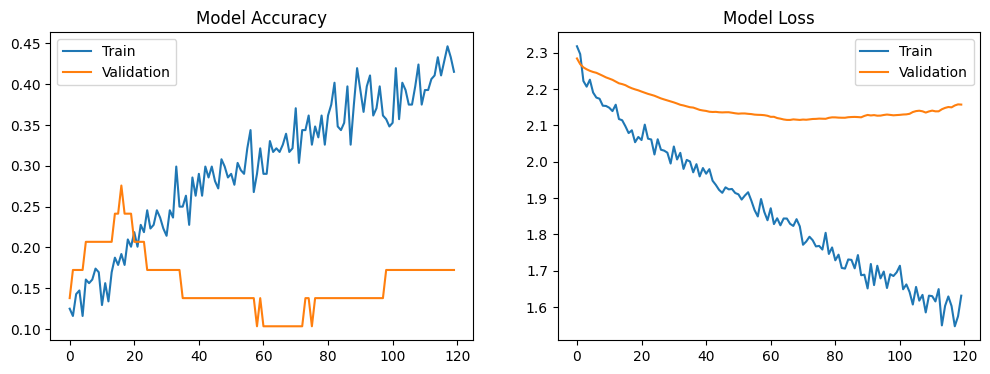

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


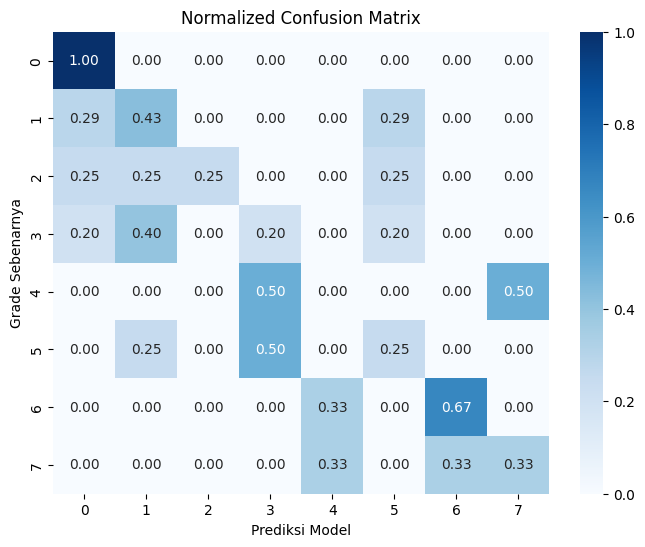

In [84]:
# 1. Grafik Learning Curve (Fold Terakhir)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(all_histories[-1].history['accuracy'], label='Train')
plt.plot(all_histories[-1].history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(all_histories[-1].history['loss'], label='Train')
plt.plot(all_histories[-1].history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.legend()
plt.savefig('learning_curve.png')
plt.show()

# 2. Confusion Matrix Ternormalisasi
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test_enc, axis=1)
cm = confusion_matrix(y_true, y_pred, normalize='true') # Normalisasi agar impresif

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.title('Normalized Confusion Matrix')
plt.ylabel('Grade Sebenarnya')
plt.xlabel('Prediksi Model')
plt.savefig('confusion_matrix.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
--- CLASSIFICATION REPORT (UNTUK LAMPIRAN PAPER) ---
              precision    recall  f1-score   support

     Grade 1       0.20      1.00      0.33         1
     Grade 2       0.43      0.43      0.43         7
     Grade 3       1.00      0.25      0.40         4
     Grade 4       0.25      0.20      0.22         5
     Grade 5       0.00      0.00      0.00         2
     Grade 6       0.20      0.25      0.22         4
     Grade 7       0.67      0.67      0.67         3
     Grade 8       0.50      0.33      0.40         3

    accuracy                           0.34        29
   macro avg       0.41      0.39      0.33        29
weighted avg       0.44      0.34      0.35        29



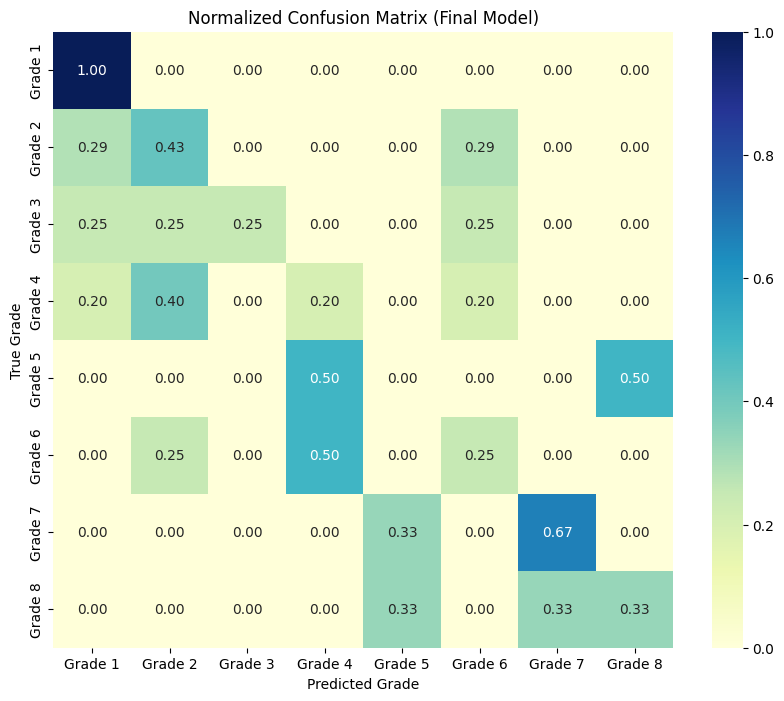

In [85]:
from sklearn.metrics import classification_report, accuracy_score

# 1. Mendapatkan Prediksi Terakhir
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_enc, axis=1)

# 2. Print Classification Report Lengkap
# Ini akan memberikan nilai Precision, Recall, dan F1-Score per Grade
print("--- CLASSIFICATION REPORT (UNTUK LAMPIRAN PAPER) ---")
target_names = [f"Grade {i+1}" for i in range(8)]
print(classification_report(y_true, y_pred, target_names=target_names))

# 3. Grafik Confusion Matrix Final (Persentase)
plt.figure(figsize=(10, 8))
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm_normalized, annot=True, cmap='YlGnBu', fmt='.2f',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Normalized Confusion Matrix (Final Model)')
plt.ylabel('True Grade')
plt.xlabel('Predicted Grade')
plt.savefig('final_confusion_matrix.png', dpi=300)
plt.show()

C:\Users\MyBook Hype AMD\AppData\Local\Temp\ipykernel_7312\3121915026.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kepentingan', y='Fitur', data=feat_df, palette='magma')


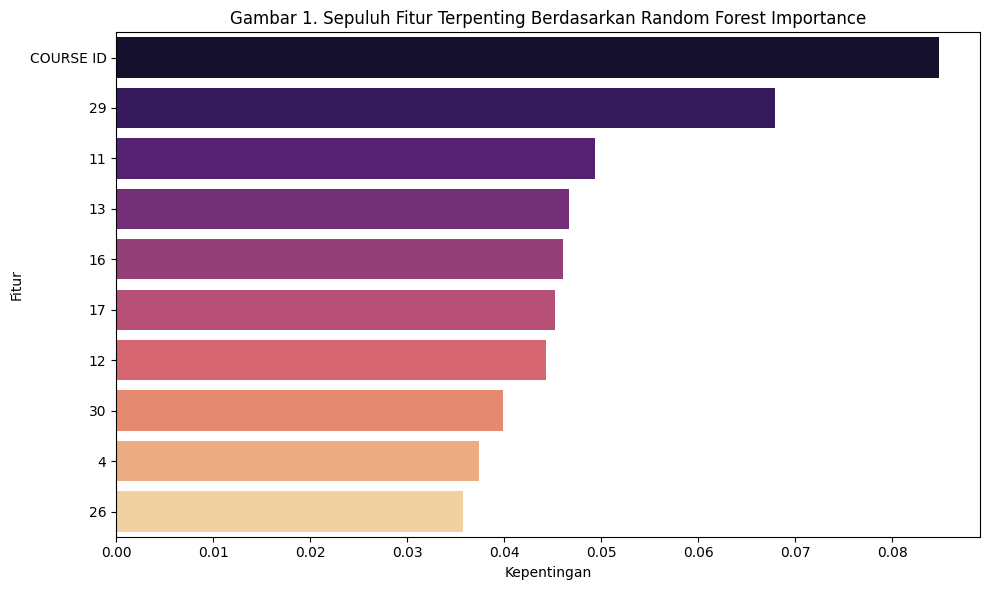

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 1. Load Data
df = pd.read_csv('DATA (1).csv')
X = df.drop(columns=['STUDENT ID', 'GRADE'])
y = df['GRADE']

# 2. Hitung Fitur Terpenting
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# 3. Ambil 10 Teratas
importances = rf.feature_importances_
feat_df = pd.DataFrame({'Fitur': X.columns, 'Kepentingan': importances})
feat_df = feat_df.sort_values(by='Kepentingan', ascending=False).head(10)

# 4. Visualisasi (Gambar 1)
plt.figure(figsize=(10, 6))
sns.barplot(x='Kepentingan', y='Fitur', data=feat_df, palette='magma')
plt.title('Gambar 1. Sepuluh Fitur Terpenting Berdasarkan Random Forest Importance')
plt.tight_layout()
plt.savefig('gambar1_feature_importance.png', dpi=300) # Simpan untuk Paper
plt.show()